<a href="https://colab.research.google.com/github/ginc23/Week4-Neural_Network/blob/main/Speech_Emotion_Recognition_via_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import nltk
import librosa
import seaborn as sns
#%matplotlib inline
# Get the critical imports out of the way

import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

RAVDESS ONLY

In [ ]:
#Emotions in the RAVDESS dataset
emotions_R ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# emotional_intensity = {
#     '01':'normal',
#     '02':'strong'
# }

statement_R = {
    '01':'kids are talking by the door',
    '02':'dogs are sitting by the door'
}

repetition_R = {
    '01':'first',
    '02':'second'
}

In [ ]:
import os, glob

def load_data_RAVDESS():
    dataframe = []
    labels = ['Actor','Gender','Emotion','Statement','Repetition']
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        dataholder = []
        file_name=os.path.basename(file)
        if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
        elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          actorCode = (file_name.split('-')[6])
          actorNum = (actorCode[0:2])
          dataholder.append('Actor '+actorNum)
          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
            dataholder.append('female')
          else:
            dataholder.append('male')
          dataholder.append(emotions_R[file_name.split("-")[2]])
          dataholder.append(statement_R[file_name.split('-')[4]])
          dataholder.append(repetition_R[file_name.split('-')[5]])

        #features = get_features(file)
          count += 1
        # '\r' + end='' results in printing over same line
        # print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
          dataframe.append((dataholder))

    df_D = pd.DataFrame.from_records(dataframe,columns=labels)
    return df_D

Plotting emotion category from dataset RAVDESS only.

In [ ]:
def load_emotion_RAVDESS():
    emotionsList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])
    return emotionsList

In [ ]:
load_data_RAVDESS()


,Actor,Gender,Emotion,Statement,Repetition
0,Actor 09,male,disgust,dogs are sitting by the door,second
1,Actor 09,male,disgust,dogs are sitting by the door,second
2,Actor 09,male,disgust,dogs are sitting by the door,first
3,Actor 09,male,fearful,kids are talking by the door,second
4,Actor 09,male,fearful,dogs are sitting by the door,first
...,...,...,...,...,...
1049,Actor 23,male,happy,kids are talking by the door,second
1050,Actor 23,male,neutral,dogs are sitting by the door,second
1051,Actor 23,male,angry,dogs are sitting by the door,first
1052,Actor 23,male,fearful,dogs are sitting by the door,second


In [ ]:
RAVDESSemotions = load_emotion_RAVDESS()

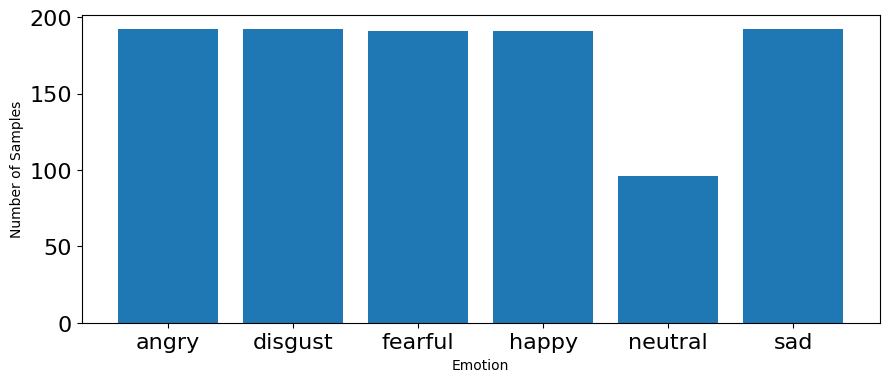

In [ ]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(RAVDESSemotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = (emotion for emotion in emotion_list),fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

Plotting Gender for dataset RAVDESS only.

In [ ]:
def load_gender_RAVDESS():
    genderList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
            genderList.append('Female')
          else:
            genderList.append('Male')

    return genderList

In [ ]:
RAVDESSgenders = load_gender_RAVDESS()

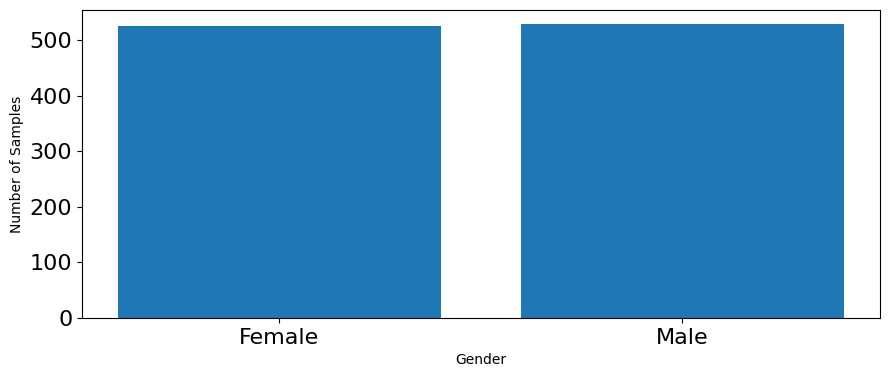

In [ ]:
# plot genders
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(RAVDESSgenders, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = (gender for gender in gender_list),fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

EMODB ONLY

In [ ]:
#Emotions in the EMODB dataset
emotions_E ={
  'F':'happy',
  'T':'sad',
  'W':'angry',
  'A':'fearful',
  'E':'disgust',
  'L':'boredom',
  'N':'neutral'

}
actor_E  = {
    '03':'24',
    '08':'25',
    '09':'26',
    '10':'27',
    '11':'28',
    '12':'29',
    '13':'30',
    '14':'31',
    '15':'32',
    '16':'33'
}

gender_E = {
    '03':'male',
    '08':'female',
    '09':'female',
    '10':'male',
    '11':'male',
    '12':'male',
    '13':'female',
    '14':'female',
    '15':'male',
    '16':'female',
}

# statement = {
#     '01':'kids are talking by the door',
#     '02':'dogs are sitting by the door'
# }

repetition_E = {
    'a':'first',
    'b':'second',
    'c':'third',
    'd':'fourth',
    'e':'fifth',
    'f':'sixth'
}

In [ ]:
import os, glob

def load_data_EMODB():
    dataframe = []
    labels = ['Actor','Gender', 'Emotion','Statement', 'Repetition']
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        dataholder = []

        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          dataholder.append('Actor '+ actor_E[file_name[0:2]])
          dataholder.append(gender_E[file_name[0:2]])

          dataholder.append(emotions_E[file_name[5]])
          dataholder.append([file_name[2:5]])
          dataholder.append(repetition_E[file_name[6]])

          count += 1
        # '\r' + end='' results in printing over same line
        # print('\r' + f' Processed {count}/{1435} audio samples',end=' ')
          dataframe.append((dataholder))
      # Return arrays to plug into sklearn's cross-validation algorithms

    df_E = pd.DataFrame.from_records(dataframe,columns=labels)
    return df_E

In [ ]:
testing1 = load_data_EMODB()

testing1['Gender'].unique()

array(['male', 'female'], dtype=object)

In [ ]:
load_data_EMODB()

,Actor,Gender,Emotion,Statement,Repetition
0,Actor 24,male,sad,[a02],first
1,Actor 24,male,angry,[a01],first
2,Actor 24,male,happy,[a01],first
3,Actor 24,male,neutral,[a01],third
4,Actor 24,male,happy,[a02],third
...,...,...,...,...,...
449,Actor 33,female,happy,[b10],second
450,Actor 33,female,sad,[b10],second
451,Actor 33,female,fearful,[b10],first
452,Actor 33,female,disgust,[b10],second


CATEGORY MISMATCHES


For the category mismatches, I decided to deal with each differently, instead of eliminating them all. One category I removed was emotional intensity, which was not specified in the EmoDB dataset, and I didn’t want to mislabel the data by listening and deciding it myself because it may not be what the speaker intended. Since the data wasn’t provided and I had no means to obtain it, I chose to remove the whole category. However, for the mismatch in the statement category, I decided not to remove it even though there weren’t any overlaps. Sentences in both data sets were clearly different, being from two different languages, but both provided a “code” in the file name that let me distinguish between different statements. I didn’t know exactly what statements were spoken in the EmoDB dataset, but the consistency will appear and be useful to analyze when we convert the data into waveform.

In [ ]:
frames = [load_data_RAVDESS(),load_data_EMODB()]
merge = pd.concat(frames)
merge.count()
merge.describe(include='all')
merge['Gender'].value_counts()

female    782
male      726
Name: Gender, dtype: int64

In [ ]:
def load_emotion_MERGE():
    emotionsList = []

    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          emotionsList.append(emotions_E[file_name[5]])

    return emotionsList

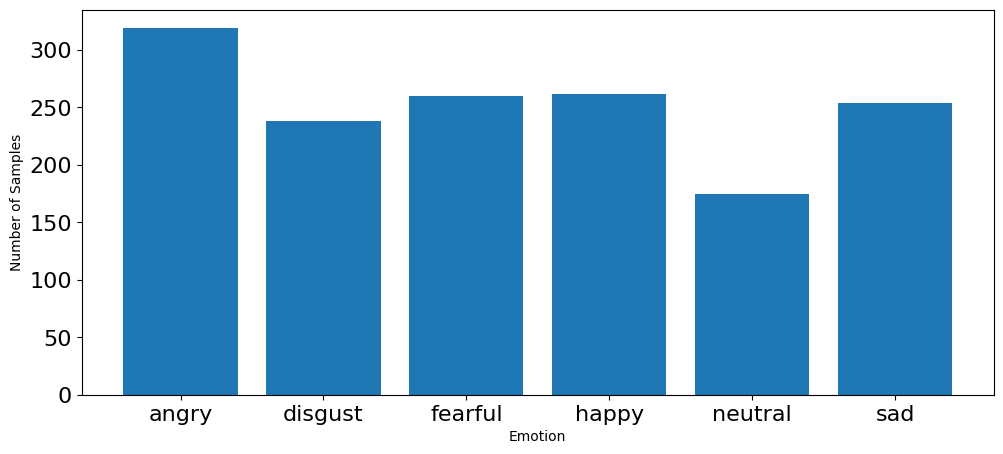

In [ ]:
# plot emotions
mergeEmotions = load_emotion_MERGE()
plt.figure(figsize=(40,5))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(mergeEmotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = (emotion for emotion in emotion_list),fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
mergeEmotions = load_emotion_MERGE()
len(mergeEmotions)

1508

In [ ]:
def load_emotion_MERGE():
    emotionsList = []

    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
          emotionsList.append(emotions_R[file_name.split("-")[2]])

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        if (file_name[5]) == ('L'):
          continue
        elif (file_name[5]) != ('L'):
          emotionsList.append(emotions_E[file_name[5]])

    return emotionsList

Plotting Gender for Combined dataset

In [ ]:
def load_gender_MERGE():
    genderList = []
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
      file_name=os.path.basename(file)
      if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
          continue
      elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):

          actorNum = file_name.split('-')[6]
          actorGen = actorNum.split('.')[0]
          if (int(actorGen)% 2) ==0:
             genderList.append('female')
          else:
             genderList.append('male')

    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
       file_name=os.path.basename(file)
       if (file_name[5]) == ('L'):
          continue
       elif (file_name[5]) != ('L'):
          genderList.append(gender_E[file_name[0:2]])

    return genderList

In [ ]:
MERGEgenders = load_gender_MERGE()

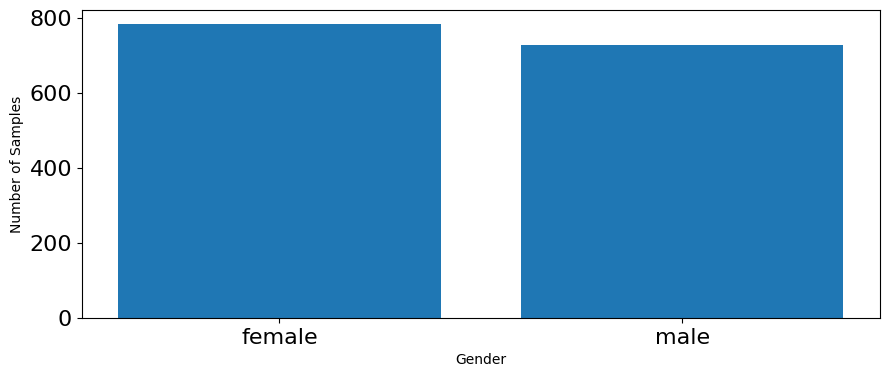

In [ ]:
# plot genders
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
gender_list, count = np.unique(MERGEgenders, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = (gender for gender in gender_list),fontsize=10)
plt.xlabel('Gender')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

EMOTION AND GENDER CATEGORY BALANCE


Within the merged datasets, both gender and emotional balance is uneven, for example, we had 56 more audio files whose speaker was female. These categories with larger samples will have more impact on the data, and give biased information.

In [ ]:
import os, glob

def load_MERGEdata():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Datasets/RAVDESS/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
         file_name=os.path.basename(file)
         if (file_name.split("-")[2] == ('02')) or (file_name.split("-")[2] ==  ('08')):
             continue
         elif (file_name.split("-")[2] != ('02')) or (file_name.split("-")[2] !=  ('08')):
             features = get_features(file)
             emotion=emotions_R[file_name.split("-")[2]]
             X.append(features)
             y.append(emotion)
             count += 1
             print('\r' + f' Processed {count}/{1508} audio samples',end=' ')
    for file in glob.glob("/content/drive/MyDrive/Datasets/EMODB/wav/Actor_*/*.wav"):
       file_name=os.path.basename(file)
       if (file_name[5]) == ('L'):
          continue
       elif (file_name[5]) != ('L'):
          features = get_features(file)
          emotion=emotions_E[file_name[5]]
          X.append(features)
          y.append(emotion)
          count += 1
          print('\r' + f' Processed {count}/{1508} audio samples',end=' ')
    return np.array(X), np.array(y)

In [ ]:
features, emotions = load_MERGEdata()

 Processed 1508/1508 audio samples 

In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
emotions_df = pd.DataFrame(emotions)

features_df



Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.683000,0.683928,0.710630,0.705208,0.732496,0.741531,0.776622,0.751703,0.755654,0.757737,...,-0.380085,-1.798686,-2.449519,0.136574,-1.975182,-1.358545,-1.719319,-1.420498,-0.595354,-0.992701
1,0.784023,0.775307,0.780571,0.700013,0.659940,0.672069,0.680253,0.706353,0.741561,0.758811,...,0.312231,-0.563979,-1.868942,1.497169,0.264672,-0.511249,-0.284905,0.802863,-0.494821,-1.259620
2,0.753914,0.742236,0.772050,0.769192,0.764030,0.780469,0.796326,0.773092,0.767141,0.780961,...,-0.875687,-0.078017,-3.065014,0.334595,-0.252048,-1.082421,-0.554702,-0.483548,-0.359480,-0.372499
3,0.779361,0.776114,0.744348,0.724711,0.724719,0.752862,0.801365,0.822931,0.767104,0.728701,...,-2.869366,-0.562084,-1.545011,-1.893366,-0.340295,-0.510655,-1.597359,-0.974046,-0.298678,0.020794
4,0.829234,0.778006,0.768941,0.795332,0.835775,0.867833,0.859369,0.784861,0.775521,0.783258,...,-0.028779,0.901367,-0.503753,0.708495,0.006597,0.854317,0.701170,0.014904,0.576033,-1.139271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.551367,0.564118,0.505336,0.524934,0.496140,0.454423,0.515791,0.536566,0.597085,0.590422,...,0.556691,4.283366,2.617795,0.711356,0.458114,3.359489,-2.563466,-3.431811,-1.883393,1.669716
1504,0.432156,0.425627,0.431573,0.449304,0.494966,0.543440,0.626419,0.734923,0.671834,0.638155,...,11.866018,9.109138,8.383128,4.919827,4.284627,1.220962,3.305987,0.983567,0.452772,0.475803
1505,0.419499,0.442788,0.571628,0.684108,0.592539,0.460164,0.425695,0.454377,0.457819,0.531090,...,2.348398,-3.527780,-5.046298,-0.564903,-1.723119,-3.831751,-3.508468,1.743801,3.360200,1.841690
1506,0.447767,0.430598,0.460157,0.503224,0.543750,0.543159,0.513875,0.534631,0.556236,0.589742,...,3.921986,4.652644,1.569165,3.393978,1.844932,1.543971,1.782868,2.295937,-0.066072,-0.303699


In [ ]:
emotions_df.value_counts()

angry      319
happy      262
fearful    260
sad        254
disgust    238
neutral    175
dtype: int64

In [ ]:
print(features_df)

           0         1         2         3         4         5         6    \
0     0.683000  0.683928  0.710630  0.705208  0.732496  0.741531  0.776622   
1     0.784023  0.775307  0.780571  0.700013  0.659940  0.672069  0.680253   
2     0.753914  0.742236  0.772050  0.769192  0.764030  0.780469  0.796326   
3     0.779361  0.776114  0.744348  0.724711  0.724719  0.752862  0.801365   
4     0.829234  0.778006  0.768941  0.795332  0.835775  0.867833  0.859369   
...        ...       ...       ...       ...       ...       ...       ...   
1503  0.551367  0.564118  0.505336  0.524934  0.496140  0.454423  0.515791   
1504  0.432156  0.425627  0.431573  0.449304  0.494966  0.543440  0.626419   
1505  0.419499  0.442788  0.571628  0.684108  0.592539  0.460164  0.425695   
1506  0.447767  0.430598  0.460157  0.503224  0.543750  0.543159  0.513875   
1507  0.582484  0.612613  0.604679  0.587842  0.573596  0.625602  0.648073   

           7         8         9    ...        170       171   

In [ ]:
features_df.to_excel('/content/drive/MyDrive/featuresMerged.xlsx')
emotions_df.to_excel('/content/drive/MyDrive/emotionsMerged.xlsx')


In [ ]:
features_df=pd.read_excel('/content/drive/MyDrive/featuresMerged.xlsx',index_col=0)
emotions_df=pd.read_excel('/content/drive/MyDrive/emotionsMerged.xlsx',index_col=0)

In [ ]:
test123 = pd.DataFrame(emotions_df)
test123

test123.value_counts()

angry      319
happy      262
fearful    260
sad        254
disgust    238
neutral    175
dtype: int64

In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.683000,0.683928,0.710630,0.705208,0.732496,0.741531,0.776622,0.751703,0.755654,0.757737,...,-0.380085,-1.798686,-2.449519,0.136574,-1.975182,-1.358545,-1.719319,-1.420498,-0.595354,-0.992701
1,0.784023,0.775307,0.780571,0.700013,0.659940,0.672069,0.680253,0.706353,0.741561,0.758811,...,0.312231,-0.563979,-1.868942,1.497169,0.264672,-0.511249,-0.284905,0.802863,-0.494821,-1.259620
2,0.753914,0.742236,0.772050,0.769192,0.764030,0.780469,0.796326,0.773092,0.767141,0.780961,...,-0.875687,-0.078017,-3.065014,0.334595,-0.252048,-1.082421,-0.554702,-0.483548,-0.359480,-0.372499
3,0.779361,0.776114,0.744348,0.724711,0.724719,0.752862,0.801365,0.822931,0.767104,0.728701,...,-2.869366,-0.562084,-1.545011,-1.893366,-0.340295,-0.510655,-1.597359,-0.974046,-0.298678,0.020794
4,0.829234,0.778006,0.768941,0.795332,0.835775,0.867833,0.859369,0.784861,0.775521,0.783258,...,-0.028779,0.901367,-0.503753,0.708495,0.006597,0.854317,0.701170,0.014904,0.576033,-1.139271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.551367,0.564118,0.505336,0.524934,0.496140,0.454423,0.515791,0.536566,0.597085,0.590422,...,0.556691,4.283366,2.617795,0.711356,0.458114,3.359489,-2.563466,-3.431811,-1.883393,1.669716
1504,0.432156,0.425627,0.431573,0.449304,0.494966,0.543440,0.626419,0.734923,0.671834,0.638155,...,11.866018,9.109138,8.383128,4.919827,4.284627,1.220962,3.305987,0.983567,0.452772,0.475803
1505,0.419499,0.442788,0.571628,0.684108,0.592539,0.460164,0.425695,0.454377,0.457819,0.531090,...,2.348398,-3.527780,-5.046298,-0.564903,-1.723119,-3.831751,-3.508468,1.743801,3.360200,1.841690
1506,0.447767,0.430598,0.460157,0.503224,0.543750,0.543159,0.513875,0.534631,0.556236,0.589742,...,3.921986,4.652644,1.569165,3.393978,1.844932,1.543971,1.782868,2.295937,-0.066072,-0.303699


In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


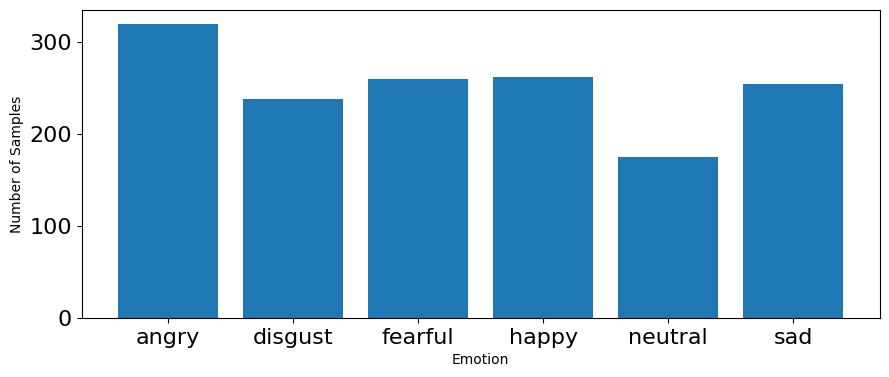

In [ ]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions_df, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features_df
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features_df
features_minmax = scaler.fit_transform(features_minmax)

In [ ]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


In [ ]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features_df,
    emotions_df,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions_df,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions_df,
    test_size=0.2,
    random_state=69
)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,RandomForestClassifier,67.22%
0,KNeighborsClassifier,59.93%
1,SVC,57.95%
2,SVC RBF kernel,53.97%
3,DecisionTreeClassifier,45.03%
5,AdaBoostClassifier,35.10%
6,GaussianNB,34.77%
7,QuadraticDiscriminantAnalysis,30.13%


Support Vector Machine Classifier

In [ ]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 43.38%


k Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 76.78%
Default kNN Model's accuracy on test set is 59.93%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 64.24%


Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on Combined training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on Combined test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on Combined training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on Combined test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on Combined training set is 100.00%
Default Random Forest Model's accuracy on Combined test set is 66.23%

Random Forest Model's accuracy on Combined training set is 100.00%
Random Forest Model's accuracy on Combined test set is 69.54%


MLP Model

In [ ]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    emotions_df,
    test_size=0.2,
    random_state=69
)

model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')



Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Unscaled MLP Model's accuracy on training set is 59.54%
Unscaled MLP Model's accuracy on test set is 44.04%


In [ ]:
#################### minmax scaled #######################
# Rebuild the training set from the minmax scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions_df,
    test_size=0.2,
    random_state=69
)

# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

#################### standard scaled #######################
# Rebuild the training set from the standard scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions_df,
    test_size=0.2,
    random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%')

MinMax scaled MLP Model's accuracy on training set is 64.51%
MinMax sacled MLP Model's accuracy on test set is 52.65%

Standard scaled MLP Model's accuracy on training set is 92.45%
Standard scaled MLP Model's accuracy on test set is 66.89%


In [ ]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions_df,
    test_size=0.2,
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=10,
    n_jobs=-1,
    verbose=10)
# Fit the models specified by the parameter grid
with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 2/10; 1/16] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd[CV 1/10; 1/16] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.463 total time=  13.3s
[CV 3/10; 1/16] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 2/10; 1/16] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.512 total time=  13.7s
[CV 4/10; 1/16] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 3/10; 1/16] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.496 total time=   9.4s
[CV 5/10; 1/16] START activation=relu, alpha=0

In [ ]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
# our default X_train, X_test are now standard scaled features since we know they're best
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions_df,
    test_size=0.2,
    random_state=69
)

model = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 70.20%


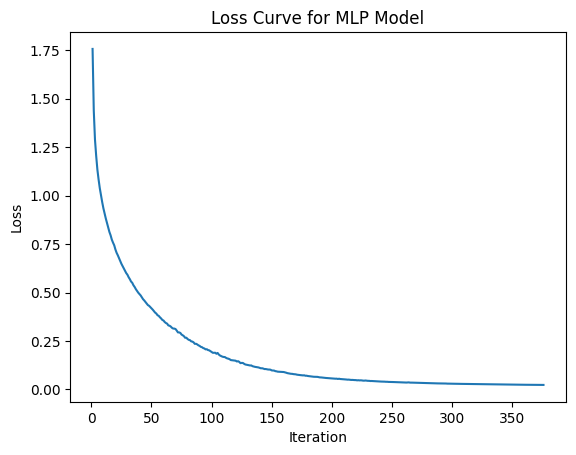

In [ ]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

Confusion Matrix

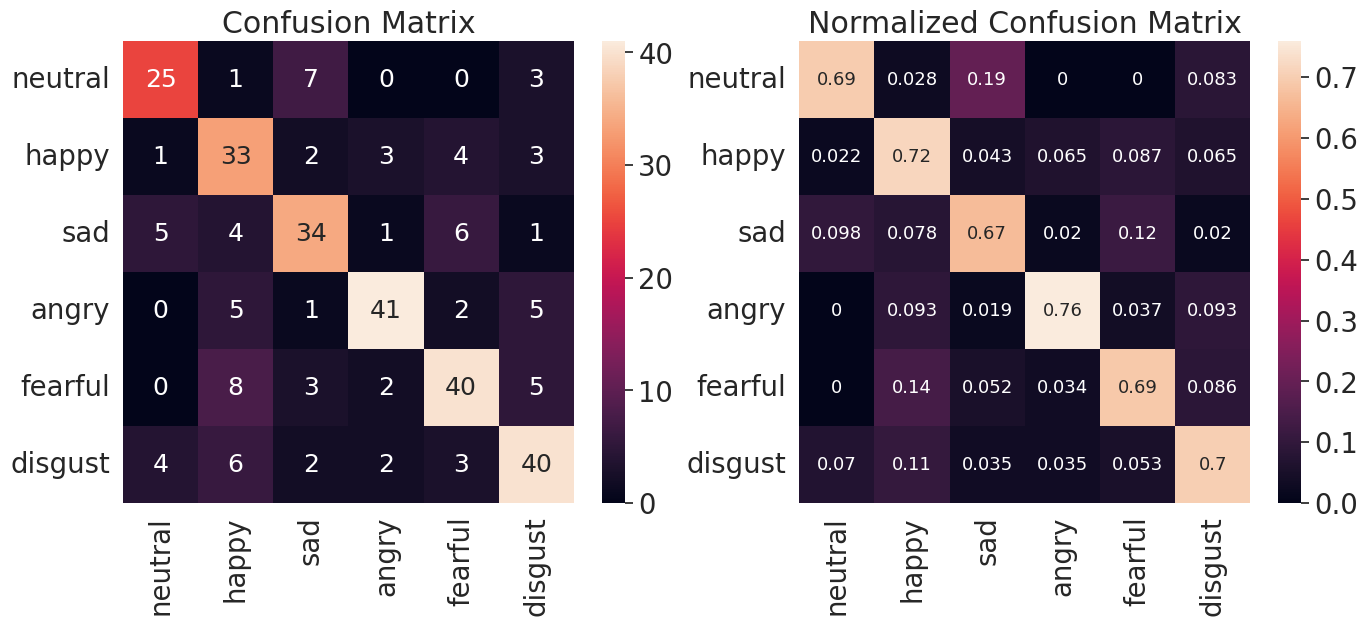

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','happy','sad','angry','fearful','disgust']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  70.530%
Test Set Precision score =  70.881%
Test Set Recall score =  70.486%
Test Set F-score score =  70.5%


K-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10,
    random_state=69,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train,y_train):



    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    test_x=X_train.iloc[test_indices]
    test_y=y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
66.94%
68.60%
69.42%
69.42%
66.12%
72.73%
67.50%
69.17%
70.83%
63.33%
Mean score of KFold CV for MLP: 68.41% ± 2.47%


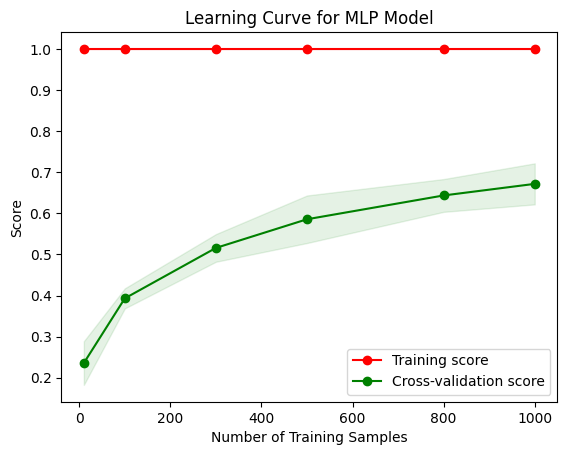

In [ ]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()